In [1]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

data_path = '/vol/bitbucket/mb4617/MRI_Crohns'
folder = 'A'
extensions = ['nii', 'nii.gz']

def load_image(end):
    main_path = os.path.join(data_path, folder, end)
    for ext in extensions:
        full_path = f'{main_path}.{ext}'
        if os.path.isfile(full_path):
            return sitk.ReadImage(full_path)
    return None

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, existing_ax=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)

    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]

    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)

    if window is None:
        window = np.max(img_array) - np.min(img_array)

    if level is None:
        level = window / 2 + np.min(img_array)

    low,high = wl_to_lh(window,level)

    if existing_ax is None:
        # Display the orthogonal slices
        fig, axes = plt.subplots(1, 3, figsize=(14, 8))
    else:
        axes = existing_ax

    axes[0].imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    axes[1].imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    axes[2].imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    axes[0].axhline(y * spacing[1], lw=1)
    axes[0].axvline(x * spacing[0], lw=1)

    axes[1].axhline(z * spacing[2], lw=1)
    axes[1].axvline(x * spacing[0], lw=1)

    axes[2].axhline(z * spacing[2], lw=1)
    axes[2].axvline(y * spacing[1], lw=1)

    if existing_ax is None:
        plt.show()

def print_image_stats(paths, images):
    for i in range(len(paths)):
        print(paths[i])
        img = images[i]
        print("Size: ", img.GetSize())
        print("Spacing: ", img.GetSpacing())
        print("Origin: ", img.GetOrigin())
        print("Direction: ", img.GetDirection())
        print()
    for img in images:
        display_image(img)
        
def display_patient(p):
    p_imgs = [p.axial_image, p.coronal_image, p.axial_postcon_image]
    fig, axes = plt.subplots(3, 3, figsize=(14, 24))

    for i in range(3):
        display_image(p_imgs[i], existing_ax=axes[i])
    plt.show()


In [2]:
a1_paths = ['A1 Axial T2', 'A1 Coronal T2','A1 Axial Postcon']

a1_images = [load_image(e) for e in a1_paths]


A1 Axial T2
Size:  (528, 528, 72)
Spacing:  (0.7575757503509521, 0.7575757503509521, 3.8500020503997803)
Origin:  (-187.13746643066406, -205.24208068847656, -100.71702575683594)
Direction:  (0.999980226260757, 0.006288647820983615, -1.915323431436786e-08, -0.006286684379028343, 0.9996681382159741, 0.024981814829928062, 0.00015712098403791622, -0.024981319908921183, 0.9996879057624949)

A1 Coronal T2
Size:  (512, 512, 34)
Spacing:  (0.791015625, 0.791015625, 3.850001811981201)
Origin:  (-194.3491973876953, -60.874107360839844, 226.67105102539062)
Direction:  (0.9999802564587489, 5.666884083526449e-06, 0.0062838412227210734, -0.006281738508524006, -0.02498183342909622, 0.9996681688779345, 0.00016264687328532474, -0.9996879052816471, -0.0249813024425245)

A1 Axial Postcon
Size:  (512, 512, 96)
Spacing:  (0.791015625, 0.791015625, 3.0000057220458984)
Origin:  (-198.94110107421875, -207.68212890625, -101.92040252685547)
Direction:  (0.99998022626016, 0.006288647874500828, -1.915323493476760

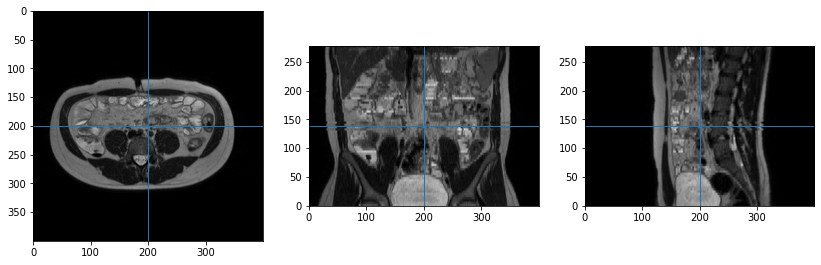

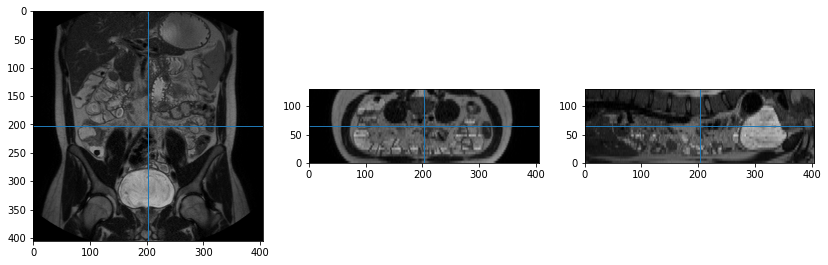

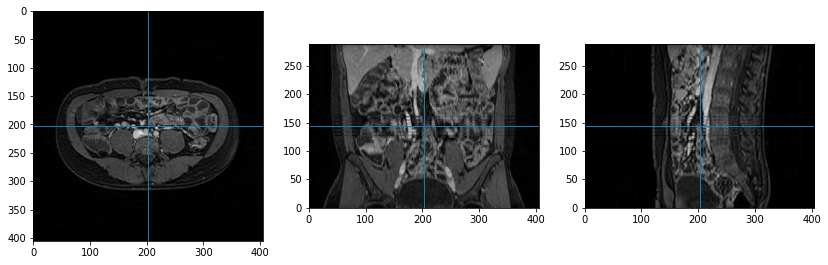

In [3]:
print_image_stats(a1_paths, a1_images)


In [24]:
from preprocess import Preprocessor
from metadata import Metadata
from np_generator import NumpyGenerator

# Reverse-engineer dimensions from desired global average pooling size (assuming three downsampling layers)
pool_size = [10, 10, 10]
input_size = [2 * (2 * (2 * x + 1) + 1) + 1 for x in pool_size]
reference_size = [x + pad for x, pad in zip(input_size, [12, 12, 12])]
k = 4
test_proportion = 0.25
print('input_size', input_size)
print('record_size', reference_size)

# Path setting
data_path = '/vol/bitbucket/mb4617/MRI_Crohns'
label_path = '/vol/bitbucket/mb4617/MRI_Crohns/labels'

abnormal_cases = list(range(1))
healthy_cases = list(range(0))

input_size [87, 87, 87]
record_size [99, 99, 99]


In [25]:
metadata = Metadata(data_path, label_path, abnormal_cases, healthy_cases, dataset_tag='')

Forming metadata


In [26]:
print(metadata.patients[0])

A1: /vol/bitbucket/mb4617/MRI_Crohns/A/A1 Axial T2.nii, /vol/bitbucket/mb4617/MRI_Crohns/A/A1 Coronal T2.nii, /vol/bitbucket/mb4617/MRI_Crohns/A/A1 Axial Postcon.nii


Preprocessing...
Cropping to Ileum...
Resampling volumes to [99, 99, 99]


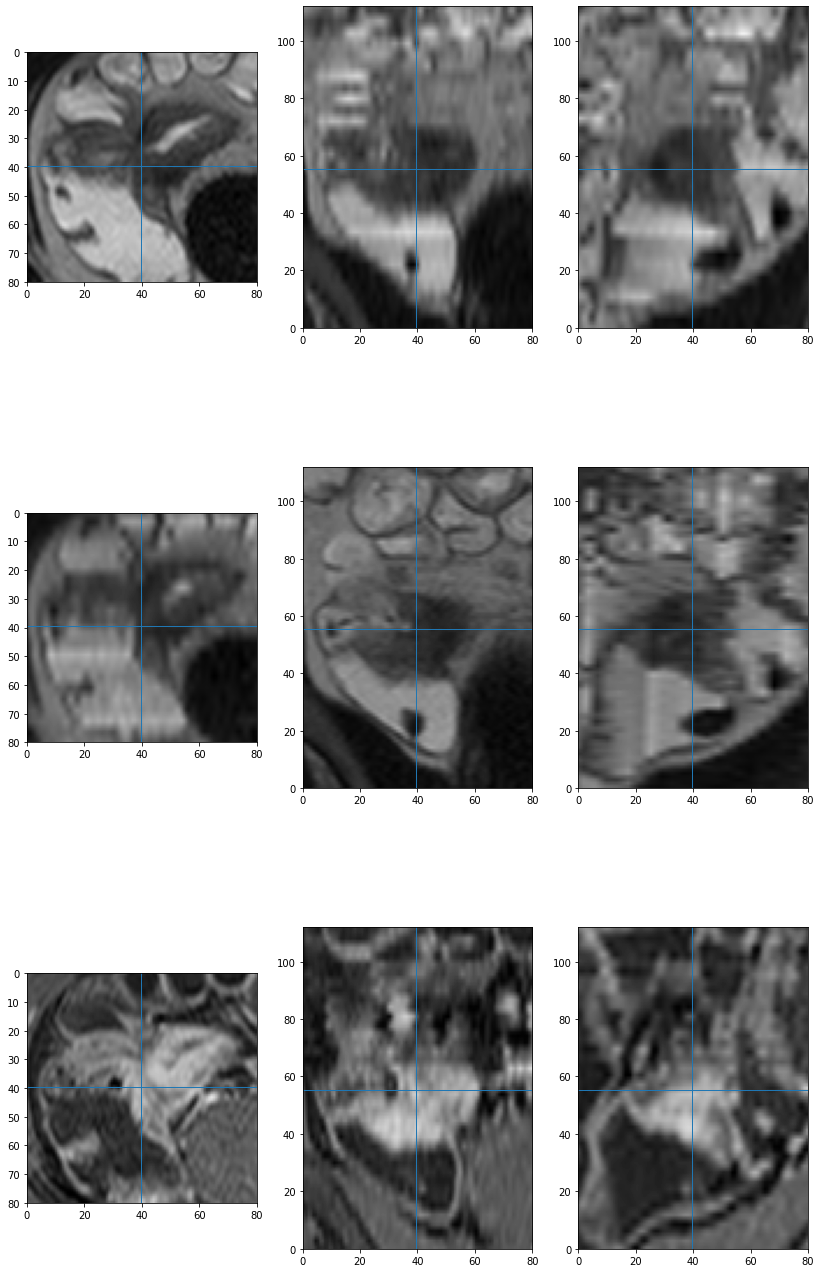

In [30]:
for p in metadata.patients:
    p.load_image_data(True, True, True)

#display_patient(metadata.patients[0])


preprocessor = Preprocessor(constant_volume_size=reference_size)
metadata.patients = preprocessor.process(metadata.patients, ileum_crop=True, region_grow_crop=False, statistical_region_crop=False)

for p in metadata.patients:
    p_imgs = [p.axial_image, p.coronal_image, p.axial_postcon_image]
    fig, axes = plt.subplots(3, 3, figsize=(14, 24))

    for i in range(3):
        display_image(p_imgs[i], existing_ax=axes[i])

    plt.show()